In [336]:
import networkx as nx
import pandas as pd 
import numpy as np 
import json
from community import community_louvain 
import matplotlib.pyplot as plt
from graspologic.partition import leiden
from scipy.stats import spearmanr
from sklearn.covariance import graphical_lasso
import gglasso
from gglasso.problem import glasso_problem
from scipy.sparse.csgraph import connected_components


In [269]:
##So the full matrices can be viewed
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [455]:
###LADING IN THE DATA

Data = pd.read_csv("Data/AMBI_data_Nov2019/data.csv", sep="\s+")
Scores = Data.filter(regex='A$', axis=1).dropna() ##Only need the columns ending in A

# Load the questions from the JSON file
with open('Data/AMBI_data_Nov2019/Questions.json', 'r') as file:
    Questions = json.load(file)


print(len(Scores))
Scores.head()



2017


,0Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,Q11A,Q12A,Q13A,Q14A,Q15A,Q16A,Q17A,Q18A,Q19A,Q20A,Q21A,Q22A,Q23A,Q24A,Q25A,Q26A,Q27A,Q28A,Q29A,Q30A,Q31A,Q32A,Q33A,Q34A,Q35A,Q36A,Q37A,Q38A,Q39A,Q40A,Q41A,Q42A,Q43A,Q44A,Q45A,Q46A,Q47A,Q48A,Q49A,Q50A,Q51A,Q52A,Q53A,Q54A,Q55A,Q56A,Q57A,Q58A,Q59A,Q60A,Q61A,Q62A,Q63A,Q64A,Q65A,Q66A,Q67A,Q68A,Q69A,Q70A,Q71A,Q72A,Q73A,Q74A,Q75A,Q76A,Q77A,Q78A,Q79A,Q80A,Q81A,Q82A,Q83A,Q84A,Q85A,Q86A,Q87A,Q88A,Q89A,Q90A,Q91A,Q92A,Q93A,Q94A,Q95A,Q96A,Q97A,Q98A,Q99A,Q100A,Q101A,Q102A,Q103A,Q104A,Q105A,Q106A,Q107A,Q108A,Q109A,Q110A,Q111A,Q112A,Q113A,Q114A,Q115A,Q116A,Q117A,Q118A,Q119A,Q120A,Q121A,Q122A,Q123A,Q124A,Q125A,Q126A,Q127A,Q128A,Q129A,Q130A,Q131A,Q132A,Q133A,Q134A,Q135A,Q136A,Q137A,Q138A,Q139A,Q140A,Q141A,Q142A,Q143A,Q144A,Q145A,Q146A,Q147A,Q148A,Q149A,Q150A,Q151A,Q152A,Q153A,Q154A,Q155A,Q156A,Q157A,Q158A,Q159A,Q160A,Q161A,Q162A,Q163A,Q164A,Q165A,Q166A,Q167A,Q168A,Q169A,Q170A,Q171A,Q172A,Q173A,Q174A,Q175A,Q176A,Q177A,Q178A,Q179A,Q180A,Q181A
0,5,2,1,2,5,2,4,4,2,4,2,4,6,3,1,6,2,1,4,1,7,1,4,5,2,2,5,2,3,7,7,2,2,4,2,1,7,1,3,2,7,6,2,2,6,2,6,4,5,3,3,2,2,2,2,4,5,3,3,4,6,4,6,3,2,2,7,2,2,4,4,5,1,2,2,4,6,2,6,3,5,2,3,6,7,2,4,1,2,2,5,2,6,2,6,7,2,2,1,4,2,7,6,6,2,2,6,2,7,1,3,6,7,2,7,3,4,2,2,1,6,6,2,1,3,6,2,2,6,2,6,5,2,5,6,2,2,2,2,6,5,7,6,3,6,2,3,3,2,1,2,6,1,2,6,4,1,4,6,6,4,4,2,1,2,3,4,7,2,1,7,2,4,2,6,7,6,1,1,3,4
1,6,2,2,6,2,2,6,3,6,5,6,5,6,2,2,5,5,1,2,2,2,3,2,5,3,2,5,5,3,6,5,3,3,3,2,1,6,2,7,5,6,2,2,5,2,3,3,2,2,5,5,2,1,1,6,3,1,5,2,2,5,2,2,3,2,5,7,6,5,2,2,1,1,5,2,3,5,6,2,2,5,2,6,3,6,6,2,2,6,1,5,6,7,6,5,2,5,2,6,3,3,6,3,3,5,5,1,5,6,5,3,6,6,2,2,3,2,2,2,5,6,6,3,5,2,3,6,3,1,2,5,5,3,2,7,2,5,2,2,6,6,5,2,2,5,2,3,3,3,2,2,6,5,6,5,1,1,6,6,2,2,2,6,5,2,3,5,3,2,1,6,5,6,6,2,3,3,5,1,2,5
2,1,1,1,7,5,4,1,7,7,5,3,7,7,3,7,7,5,1,7,7,7,4,5,7,4,1,7,7,7,7,7,3,7,2,5,7,7,5,7,7,5,4,7,4,1,5,1,7,7,7,4,2,5,1,4,1,7,7,1,7,7,2,7,5,7,4,7,7,7,3,7,7,4,1,7,7,7,7,7,7,3,7,1,3,7,7,1,7,4,7,7,7,7,5,2,7,7,2,7,5,5,7,7,1,4,7,6,7,7,6,5,4,7,4,5,7,7,7,7,7,7,7,7,7,7,3,7,7,7,7,7,7,6,7,7,7,6,1,1,7,7,7,1,6,7,1,7,7,7,1,7,7,7,7,6,4,1,5,7,7,2,7,7,2,4,6,7,2,4,5,7,3,4,7,7,3,7,7,7,7,7
3,2,6,6,7,2,7,2,5,6,6,7,6,6,3,4,6,7,2,6,6,2,7,5,6,7,2,7,6,7,4,1,6,6,6,6,6,2,7,6,6,6,5,6,7,2,6,6,6,6,6,6,6,7,7,6,2,5,6,6,6,6,2,5,7,7,6,3,6,7,2,5,6,7,7,6,7,6,6,2,5,5,2,2,1,2,7,2,7,7,2,1,7,6,7,6,2,7,7,6,2,7,5,1,1,6,5,2,7,7,6,7,6,2,6,6,2,1,7,6,7,3,7,2,7,2,6,6,4,6,7,7,6,6,6,4,2,4,2,1,7,6,6,7,1,2,1,6,6,6,2,1,5,7,7,2,7,6,6,7,4,6,5,7,7,4,7,2,7,4,6,5,7,6,6,5,1,6,1,1,5,6
4,1,7,5,7,7,3,5,1,7,4,2,7,1,1,7,7,5,2,6,7,1,2,3,7,7,2,7,7,7,5,7,4,7,7,6,4,7,6,3,5,2,1,7,7,5,7,6,1,2,2,2,6,1,1,7,7,7,7,2,7,1,1,3,7,6,2,3,7,7,6,7,2,2,1,7,7,7,7,7,6,2,1,2,1,3,7,1,2,2,7,7,7,3,7,7,7,5,7,6,2,7,5,7,2,1,7,1,1,2,7,6,1,2,5,7,4,6,7,6,7,5,4,7,7,2,6,7,7,6,7,1,7,7,6,2,6,6,1,1,5,3,7,6,1,2,2,7,7,7,1,2,6,7,7,2,3,2,7,7,6,1,6,7,7,5,6,1,3,1,5,7,7,1,6,7,2,6,7,2,7,7


In [538]:
##COMPUTING SPEARMAN CORRELATIONS BETWEEN QUESTIONS AND ROBUSTLY ESTIMATING COVAR MATRIX FROM THIS


# Calculate the Spearman correlation matrix
correlation_matrix, _ = spearmanr(Scores, axis=0)

# Apply the transformations to the Spearman correlations
transformed_correlation_matrix = 2 * np.sin(np.pi / 6 * correlation_matrix)

# Calculate the standard deviations
std_devs = np.std(Scores, axis=0)

# Construct the covariance matrix
covar_matrix = transformed_correlation_matrix * np.outer(std_devs, std_devs)

print(covar_matrix)

[[ 3.03909334 -0.44103544  0.19910905 ... -0.12875197 -1.39696297
  -0.31343845]
 [-0.44103544  3.72709313 -0.12881959 ...  0.1709049   0.45162418
   0.37511892]
 [ 0.19910905 -0.12881959  3.38536225 ...  1.02907104 -0.12492735
  -0.38026555]
 ...
 [-0.12875197  0.1709049   1.02907104 ...  3.83545958 -0.06330034
  -0.48454299]
 [-1.39696297  0.45162418 -0.12492735 ... -0.06330034  3.06733519
   0.58173574]
 [-0.31343845  0.37511892 -0.38026555 ... -0.48454299  0.58173574
   2.51389466]]


ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 36 iterations with status: optimal.
ADMM terminated after 55 iterations with status: optimal.
ADMM terminated after 76 iterations with status: optimal.
ADMM terminated after 104 iterations with status: optimal.
ADMM terminated after 174 iterations with status: optimal.
ADMM terminated after 210 iterations with status: optimal.
ADMM terminated after 249 iterations with status: optimal.
ADMM terminated after 219 iterations with status: optimal.
ADMM terminated after 71 iterations with status: optimal.
ADMM terminated after 51 iterations with status: optimal.
ADMM terminated after 79 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
Best lambda: 0.3593813663804626
ADMM terminated after 324 iterations with status: optimal.


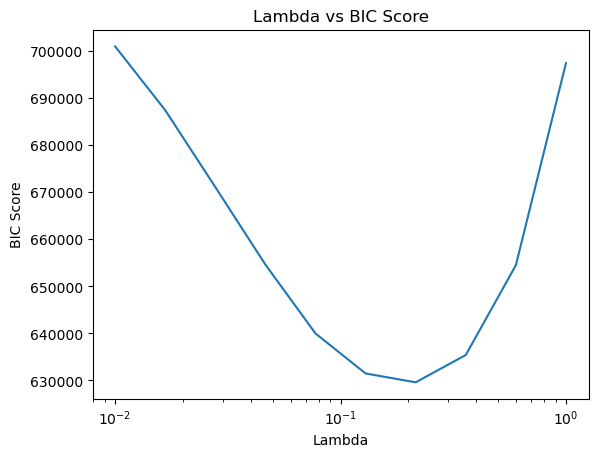

In [488]:
##USING EBIC MODEL SELECTION TO DETERMINE BEST ALPHA VALUE FOR GLASSO REGULARIZATION

# Initialize the glasso_problem instance
glasso = glasso_problem(S=covar_matrix, N=2016, reg='GGL', do_scaling=False)

# Set model selection parameters
# The grid search will be done over a range of lambda1 values
modelselect_params = {
    'lambda1_range': np.logspace(-2, 0, 10)  # Adjust the range and number of values as needed
}

# Perform model selection to find the best lambda using eBIC criterion
glasso.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=.5)


best_lambda = glasso.reg_params['lambda1']
print(f'Best lambda: {best_lambda}')

glasso.solve()

# Access the solution, which is the estimated precision matrix
precision_matrix = glasso.solution.precision_

# Compute the partial correlation matrix from the precision matrix
partial_corr_matrix = -precision_matrix / np.sqrt(np.outer(np.diag(precision_matrix), np.diag(precision_matrix)))
np.fill_diagonal(partial_corr_matrix, 1)  # Set the diagonal to 1 for the partial correlation matrix

# print('Partial Correlation Matrix:')
# print(partial_corr_matrix)

# Extract BIC scores from model selection statistics for different gamma values
# Since the output structure provided lists BIC scores under different gamma values, we will combine them
bic_scores = []
lambda1_range = modelselect_params['lambda1_range']
for gamma in glasso.modelselect_stats['BIC']:
    bic_scores.extend(glasso.modelselect_stats['BIC'][gamma].flatten())

# Plotting the BIC scores for different lambda values
plt.plot(lambda1_range, bic_scores[:len(lambda1_range)])
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('BIC Score')
plt.title('Lambda vs BIC Score')
plt.show()


In [489]:
covariance_df = pd.DataFrame(covar_matrix)
#covariance_df.head(181)

In [583]:
##PERFORMING GLASSO REGULARIZATION AND COMPUTING ADJACENCY MATRIX

# Set the alpha parameter for lasso regularization
alpha = .36 
##.955 is where openness joins the main network and all latent variables represented
##.655 is where the graph becomes fully connected
##.78 where all but one node is connected (Q 128 a strong outlier)
## .36 recommended as optimal regularization value according to EBIC model selection

max_iter = 2000

# Fit the graphical lasso model to the covariance matrix
precision_matrix, _ = graphical_lasso(covar_matrix, alpha=alpha, max_iter=max_iter)

# Normalize the precision matrix to obtain the partial correlation matrix
partial_correlation_matrix = -precision_matrix / np.sqrt(precision_matrix.diagonal()[:, np.newaxis] * precision_matrix.diagonal())

# Set diagonal elements to 0
np.fill_diagonal(partial_correlation_matrix, 0.0)

adjacency_matrix = pd.DataFrame(partial_correlation_matrix).round(3)
#adjacency_matrix.head(181)


In [584]:
##ASSESSING NETWORK TRANSITIVITY AND CONNECTEDNESS

# Function to check if the graph is transitive
def is_transitive(adjacency_matrix):
    return np.all((adjacency_matrix @ adjacency_matrix) >= adjacency_matrix)

# Convert partial correlation matrix to adjacency matrix
adjacency_matrix_ = np.abs(partial_correlation_matrix) > 0


n_components, labels = connected_components(adjacency_matrix_)
is_connected = n_components == 1
is_transitive_graph = is_transitive(adjacency_matrix_)

print("Is the graph connected?", is_connected)
print("Is the graph transitive?", is_transitive_graph)

Is the graph connected? True
Is the graph transitive? True


In [585]:
##CHECKING FOR QUESTIONS WITH NO CORRELATIONS (COMPLETELY DISCONNECTED)

# Assuming partial_correlation_matrix is your partial correlation matrix
num_zero_columns = np.sum(np.all(partial_correlation_matrix == 0, axis=0))

print("Number of columns with all zero correlations:", num_zero_columns)


Number of columns with all zero correlations: 0


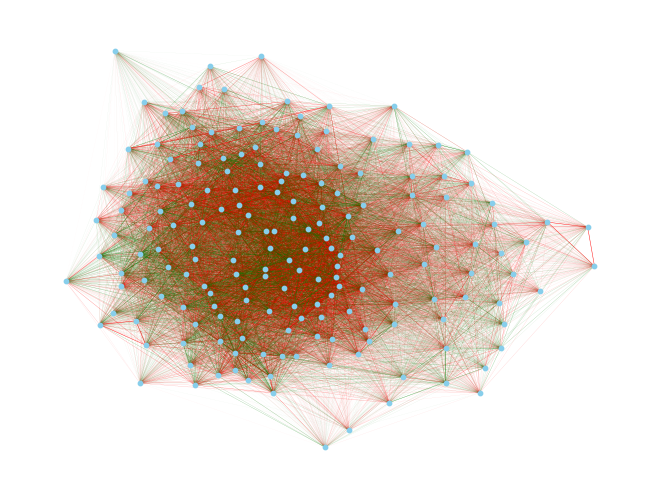

In [613]:
##CONSTRUCTING AND VISUALIZING THE NETWORK

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph using the keys from the questions dictionary
G.add_nodes_from(Questions.keys())

# Add question attributes to nodes
nx.set_node_attributes(G, Questions, name='question')

# Iterate over the keys of the Questions dictionary
for i, node1 in enumerate(Questions):
    for j, node2 in enumerate(Questions):
        if i < j:
            weight = adjacency_matrix.loc[i, j]
            abs_weight = abs(weight)
            
            if abs_weight > 0.0001:
                # Add edges with the absolute weight, distinguishing positive and negative correlations with colours
                if weight > 0:
                    G.add_edge(node1, node2, weight=abs_weight, color='green')  # Positive correlation
                else:
                    G.add_edge(node1, node2, weight=abs_weight, color='red')  # Negative correlation
 
 
# Define edge thickness based on weight
edge_thickness = [weight/2 for _, _, weight in G.edges(data='weight')]

# Visualize the graph
pos = nx.spring_layout(G) 
edge_colors = [data['color'] for _, _, data in G.edges(data=True)]
nx.draw(G, pos, with_labels=False, edge_color=edge_colors, node_color='skyblue', node_size=10, width=edge_thickness)




In [587]:
##ASSESSING NETWORK CONNECTEDNESS AND DISCONNECTED COMPONENTS
# Detect connected components in the graph
connected_components = list(nx.connected_components(G))

# Print the number of connected components
print("Number of connected components:", len(connected_components))

# Print the size of each connected component
for i, component in enumerate(connected_components):
    print(f"Component {i+1} size:", len(component))


###One network consisting of 96 nodes, the rest of the nodes are disconnected from everything else

Number of connected components: 1
Component 1 size: 181


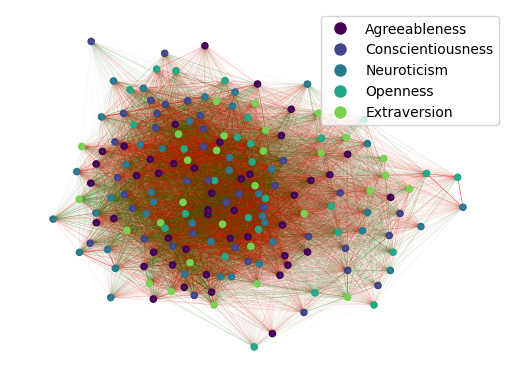

In [614]:
##DEFINING AND VISUALIZING PERSONALITY MODEL (LARGEST CONNECTED COMPONENT)

# Sort the list of connected components by their length in descending order
sorted_components = sorted(connected_components, key=len, reverse=True)

largest_component = max(connected_components, key=len)

# Create a new graph containing only the largest connected component
G_largest_component = G.subgraph(largest_component).copy()

# Visualize the largest connected component (optional)
pos_largest_component = nx.spring_layout(G_largest_component)  # Example layout
node_colors = [community_color_map[m] for m in membership]
nx.draw_networkx_nodes(G_largest_component, pos, node_size=20, node_color=node_colors)
# patches = [plt.Line2D([0], [0], marker='o', color='w', label=label_names[community],
#                       markersize=10, markerfacecolor=color) for community, color in community_color_map.items()]
# plt.legend(handles=patches)
nx.draw(G_largest_component, pos, font_size=5, edge_color=edge_colors, node_size = .01, node_color='skyblue', width= edge_thickness)


In [589]:
##QUESTIONS IN PERSONALITY MODEL

# Create a dictionary of questions in the largest connected component
questions_in_largest_component = {node: Questions[node] for node in largest_component}

# # Print the dictionary of questions in the largest connected component
# print("Questions in the largest connected component:")
# print(questions_in_largest_component)

In [569]:
##ASSESSING NETWORK SUBCOMPONENTS
second_largest_component = sorted_components[1]
questions_in_second_largest = {node: Questions[node] for node in second_largest_component}

print("Questions in the second largest connected component:")
print(questions_in_second_largest)

third_largest_component = sorted_components[2]
questions_in_third_largest = {node: Questions[node] for node in third_largest_component}

print("Questions in the third largest connected component:")
print(questions_in_third_largest)

fourth_largest_component = sorted_components[3]
questions_in_fourth_largest = {node: Questions[node] for node in fourth_largest_component}

print("Questions in the third largest connected component:")
print(questions_in_fourth_largest)


Questions in the second largest connected component:
{'Q94': {'question': 'I am open to new experiences.'}, 'Q132': {'question': 'I would love to explore strange places.'}, 'Q92': {'question': 'I like to visit new places.'}}


In [590]:
##CLUSTERING
# Run the Leiden algorithm
partition = leiden(G_largest_component)
community_questions = {}
membership = []


# Iterate through the keys and values of the partition dictionary
for node, community_id in partition.items():
    # Get the question corresponding to the node index
    question = Questions.get(node)
    if question is not None:
        # Check if the community ID already exists in the dictionary
        if community_id in community_questions:
            # Append the question to the list of questions for that community
            community_questions[community_id].append(question)
        else:
            # If the community ID doesn't exist, create a new list with the question
            community_questions[community_id] = [question]
    membership.append(community_id)

# Print questions by community
for community_id, questions in community_questions.items():
    print(f"Community {community_id}:")
    for idx, question in enumerate(questions, start=1):
        print(f"  {idx}. {question}")


Community 4:
  1. {'question': 'I am under constant pressure.'}
  2. {'question': "I don't care what others think."}
  3. {'question': 'I wonder how I got to be the way that I am.'}
  4. {'question': 'I worry about being embarrassed.'}
  5. {'question': "I don't enjoy being the object of jokes."}
  6. {'question': 'I feel short-changed in life.'}
  7. {'question': 'I have never cared much what others thought of me.'}
  8. {'question': 'I have time for play and relaxation.'}
  9. {'question': 'I have frequent mood swings.'}
  10. {'question': 'I feel a sense of worthlessness or hopelessness.'}
  11. {'question': 'I am relaxed most of the time.'}
  12. {'question': 'I check on things more often than necessary.'}
  13. {'question': 'I panic easily.'}
  14. {'question': 'I worry about things.'}
  15. {'question': 'I often have the feeling that others laugh or talk about me.'}
  16. {'question': 'I feel that life has no meaning.'}
  17. {'question': 'I worry about what people think of me.'}

In [594]:
###CALCULATING MODULARITY SCORES

##creating partition dict
partition_dict = {node: community_id for node, community_id in partition.items()}

#Computing modularity score
modularity_score = community_louvain.modularity(partition_dict, G_largest_component)

print(f"Modularity Score: {modularity_score}")

Modularity Score: 0.20984347083646582


In [593]:
##BETWEENNESS
# Creating distance values from edge weights
for u, v, data in G_largest_component.edges(data=True):
    data['weight'] = abs(data['weight'])
    data['distance'] = 1/data['weight']

# Now calculate betweenness centrality with adjusted weights
betweenness_centrality = nx.betweenness_centrality(G_largest_component, weight= 'distance')

# Sort nodes by betweenness centrality in descending order
sorted_nodes_by_betweenness = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)

# Print the most influential nodes by betweenness centrality
print("Most influential nodes by betweenness centrality:")
for node in sorted_nodes_by_betweenness[:10]:  # Print top 15 most influential nodes
    question = Questions[node]['question'] if node in Questions else "N/A"
    print(f"{question} Betweenness: {betweenness_centrality[node]:.3f}")

Most influential nodes by betweenness centrality:
I feel emotions with extreme intensity. Betweenness: 0.065
I have frequent mood swings. Betweenness: 0.059
I like to solve complex problems. Betweenness: 0.058
I feel a sense of worthlessness or hopelessness. Betweenness: 0.053
I have a colorful and dramatic way of talking about things. Betweenness: 0.049
I am very shy in social situations. Betweenness: 0.046
I see myself as a good leader. Betweenness: 0.044
I am easily intimidated. Betweenness: 0.036
I panic easily. Betweenness: 0.034
I feel that life has no meaning. Betweenness: 0.032


In [483]:
##DEGREE
# Calculate degree centrality
degree_centrality = G_largest_component.degree(weight='weight')

# Sort nodes by degree centrality in descending order
sorted_nodes_by_degree = sorted(degree_centrality, key=lambda x: x[1], reverse=True)

# Print the most influential nodes by degree centrality
print("Most influential nodes by degree centrality:")
for node, centrality in sorted_nodes_by_degree[:10]:  # Print top 15 most influential nodes
    question = Questions[node]['question'] if node in Questions else "N/A"
    print(f"{question} Degree: {centrality:.2f}")

Most influential nodes by degree centrality:
I am very shy in social situations. Degree: 24.23
I am the life of the party. Degree: 23.09
I am skilled in handling social situations. Degree: 22.81
I talk to a lot of different people at parties. Degree: 22.71
I feel a sense of worthlessness or hopelessness. Degree: 22.65
I see myself as a good leader. Degree: 22.02
I take charge. Degree: 21.28
I love to be the center of attention. Degree: 21.18
I seem to derive less enjoyment from interacting with people than others do. Degree: 21.02
I am often in a bad mood. Degree: 20.99


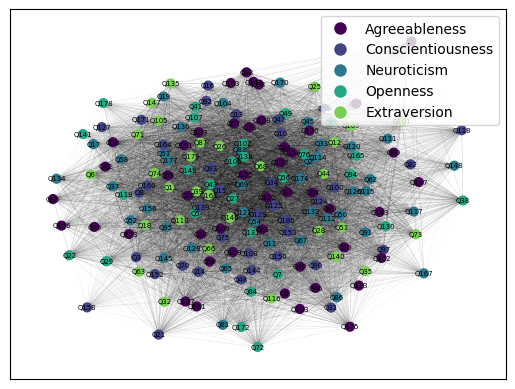

In [615]:
##VISUALIZE THE NETWORK

label_names = {
    0: "Agreeableness",
    1: "Conscientiousness",
    2: "Neuroticism",
    3: "Openness",
    4: "Extraversion",
}
edge_weights = [abs(data['weight']) for u, v, data in G_largest_component.edges(data=True)]

for u, v, data in G_largest_component.edges(data=True):
    data['weight'] = abs(data['weight'])/2

# Visualization
pos = nx.kamada_kawai_layout(G_largest_component, weight='weight')  # positions for all nodes

# Create a list of unique communities
unique_communities = list(set(membership))

# Define a colormap
cmap = plt.get_cmap('viridis')

# Create a color map with the same length as the number of communities
colors = [cmap(i / len(unique_communities)) for i in range(len(unique_communities))]

# Create a dictionary to map community to color
community_color_map = {community: colors[i] for i, community in enumerate(unique_communities)}

# Draw nodes with colors according to their community membership
node_colors = [community_color_map[m] for m in membership]
nx.draw_networkx_nodes(G_largest_component, pos, node_size=40, node_color=node_colors)

# Draw edges with width proportional to absolute value of edge weight
edge_weights = [abs(data['weight']) for u, v, data in G_largest_component.edges(data=True)]
nx.draw_networkx_edges(G_largest_component, pos, width=edge_weights, alpha=.3)

# Draw labels
nx.draw_networkx_labels(G_largest_component, pos, font_size=5, font_family="sans-serif")

# Create custom legend with label names
patches = [plt.Line2D([0], [0], marker='o', color='w', label=label_names[community],
                      markersize=10, markerfacecolor=color) for community, color in community_color_map.items()]
plt.legend(handles=patches)

plt.show()


In [52]:
print(Questions)

{'Q1': {'question': 'I rarely worry.'}, 'Q2': {'question': 'I often eat too much.'}, 'Q3': {'question': 'I usually like to spend my free time with people.'}, 'Q4': {'question': 'I take charge.'}, 'Q5': {'question': 'I am always busy.'}, 'Q6': {'question': 'I radiate joy.'}, 'Q7': {'question': 'I do not like poetry.'}, 'Q8': {'question': 'I distrust people.'}, 'Q9': {'question': 'I tell other people what they want to hear so that they will do what I want them to do.'}, 'Q10': {'question': 'I anticipate the needs of others.'}, 'Q11': {'question': 'I believe that I am better than others.'}, 'Q12': {'question': 'I sympathize with the homeless.'}, 'Q13': {'question': 'I keep things tidy.'}, 'Q14': {'question': 'I am a highly disciplined person.'}, 'Q15': {'question': 'I jump into things without thinking.'}, 'Q16': {'question': 'I admire a really clever scam.'}, 'Q17': {'question': 'I like to own things that impress people.'}, 'Q18': {'question': "I try to be with someone else when I'm feeli

In [604]:
print(G_largest_component)

Graph with 181 nodes and 16177 edges
